# F1 Driver Performance Analytics

## Overview
This notebook performs comprehensive driver performance analysis across F1 history (1950-2020):

### Analysis Objectives:
1. **Identify top performers** by career points, wins, and podiums
2. **Measure consistency** through finish position variance
3. **Analyze reliability** via DNF (Did Not Finish) rates
4. **Evaluate efficiency** using win rate and points-per-race metrics
5. **Visualize trends** in driver performance patterns

### Key Metrics We Calculate:
- **Total Career Points** - Overall performance indicator
- **Win Rate** - Percentage of races won
- **Podium Rate** - Percentage of top-3 finishes
- **DNF Rate** - Reliability measure (lower is better)
- **Consistency Score** - Standard deviation of finishing positions (lower is better)
- **Position Gain** - Average grid position vs final position

### Expected Outputs:
- Performance visualizations saved to `images/` folder
- Intelligence report saved to `../reports/driver_intelligence_report.md`

## Import Required Libraries

We'll use:
- **pandas & numpy**: Data manipulation and statistical calculations
- **matplotlib & seaborn**: Creating professional-quality visualizations
- **os**: Managing file paths and directories

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Plot Style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [2]:
OUTPUT_DIR = "../images"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Load Prepared Data

### Data Sources:
- **clean_results.csv**: Race results with driver/team information
- **clean_lap_times.csv**: Individual lap timing data
- **clean_pit_stops.csv**: Pit stop durations
- **status.csv**: DNF reason codes (from original Kaggle dataset)

These files were prepared in the `data_prep.ipynb` notebook.

In [3]:
def load_data():
    print("Loading datasets...")
    results = pd.read_csv("../data/clean_results.csv")
    laps = pd.read_csv("../data/clean_lap_times.csv")
    pits = pd.read_csv("../data/clean_pit_stops.csv")
    
    # Load status.csv
    status_path = "/Users/punarvashu/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/status.csv"
    if os.path.exists(status_path):
        status = pd.read_csv(status_path)
    else:
        print("WARNING: status.csv not found at expected path. Trying local directory.")
        try:
            status = pd.read_csv("status.csv")
        except FileNotFoundError:
            print("ERROR: status.csv not found. DNF analysis will be limited.")
            status = pd.DataFrame(columns=['statusId', 'status'])
            
    print(f"Loaded Results: {results.shape}")
    print(f"Loaded Laps: {laps.shape}")
    print(f"Loaded Pits: {pits.shape}")
    
    return results, laps, pits, status

In [4]:
results, laps, pits, status = load_data()

Loading datasets...
Loaded Results: (26759, 28)
Loaded Laps: (589081, 14)
Loaded Pits: (11371, 15)


## Feature Engineering

### Why Create New Features?
Raw data doesn't always contain the metrics we want to analyze. We need to derive meaningful features from the base data.

### Features We Create:

#### 1. **Position Gain**
   - Formula: `Grid Position - Final Position`
   - Positive value = gained positions (overtaking)
   - Negative value = lost positions
   - Example: Started P10, finished P5 = +5 gain

#### 2. **Performance Flags**
   - `win_flag`: Did the driver win? (1 = Yes, 0 = No)
   - `podium_flag`: Did the driver finish top 3?
   - These binary flags make counting wins/podiums easy

#### 3. **DNF Flag**
   - Uses status codes to identify "Did Not Finish"
   - StatusId 1 = "Finished", 11-19 = "Lapped but finished"
   - All other codes = DNF (crash, mechanical, disqualification)

#### 4. **Pit Stop Metrics** (Aggregated per Race)
   - `pit_stop_count`: Number of pit stops in each race
   - `avg_pit_duration`: Average time spent in pits
   - Helps analyze strategy effectiveness

#### 5. **Lap Time Metrics** (Aggregated per Race)
   - `avg_race_lap_time`: Mean lap time for the race
   - `lap_time_std`: Consistency of lap times (lower = more consistent)

In [5]:
def feature_engineering(results, laps, pits, status):
    print("\n--- Feature Engineering ---")
    
    # 1. Position Gain
    results['position_gain'] = np.where(results['grid'] > 0, results['grid'] - results['positionOrder'], 0)
    
    # 2. Key Flags
    results['win_flag'] = (results['positionOrder'] == 1).astype(int)
    results['podium_flag'] = (results['positionOrder'] <= 3).astype(int)
    
    # 3. DNF Flag
    results = pd.merge(results, status, on='statusId', how='left')
    finished_mask = results['status'].str.contains('Finished|Lag|\+.*Lap', case=False, regex=True, na=False)
    results['dnf_flag'] = (~finished_mask).astype(int)
    
    # 4. Pit Stop Metrics (Aggregated per driver-race)
    pit_agg = pits.groupby(['raceId', 'driverId']).agg(
        pit_stop_count=('stop', 'max'),
        avg_pit_duration=('milliseconds', 'mean')
    ).reset_index()
    
    results = pd.merge(results, pit_agg, on=['raceId', 'driverId'], how='left')
    results['pit_stop_count'] = results['pit_stop_count'].fillna(0)
    
    # 5. Lap Time Metrics (Aggregated per driver-race)
    lap_agg = laps.groupby(['raceId', 'driverId']).agg(
        avg_race_lap_time=('milliseconds', 'mean'),
        lap_time_std=('milliseconds', 'std')
    ).reset_index()
    
    results = pd.merge(results, lap_agg, on=['raceId', 'driverId'], how='left')
    
    print("Features added: position_gain, win_flag, podium_flag, dnf_flag, pit metrics, lap metrics.")
    return results

<>:13: SyntaxWarning: invalid escape sequence '\+'
<>:13: SyntaxWarning: invalid escape sequence '\+'
/var/folders/8h/2y7xz9gx3xb4c1bvtgwl9xqh0000gn/T/ipykernel_74159/1074317914.py:13: SyntaxWarning: invalid escape sequence '\+'
  finished_mask = results['status'].str.contains('Finished|Lag|\+.*Lap', case=False, regex=True, na=False)


In [6]:
results_enriched = feature_engineering(results, laps, pits, status)


--- Feature Engineering ---
Features added: position_gain, win_flag, podium_flag, dnf_flag, pit metrics, lap metrics.


## Compute Career Statistics

### Aggregation Strategy
We group all race results by driver to calculate career-long statistics.

### Metrics Calculated:

#### **Volume Metrics** (Raw Counts)
- `total_races`: Number of races entered
- `total_points`: Career points accumulated
- `total_wins`: Number of race victories
- `total_podiums`: Number of top-3 finishes
- `total_dnfs`: Number of retirements

#### **Position Metrics**
- `avg_finish_pos`: Average finishing position (lower is better)
- `global_consistency`: Std dev of finish positions (lower = more consistent)
- `avg_position_gain`: Mean positions gained/lost from grid

#### **Efficiency Metrics** (Rates)
- `points_per_race`: Total points ÷ total races
- `win_rate`: Wins ÷ races (as percentage)
- `podium_rate`: Podiums ÷ races
- `dnf_rate`: DNFs ÷ races (reliability indicator)

### Why These Metrics Matter:
- **Win rate** shows conversion efficiency (quality over quantity)
- **DNF rate** reveals car reliability and driving style
- **Consistency** indicates predictable performance
- **Points per race** normalizes across different eras

In [7]:
def compute_driver_analytics(df):
    print("\n--- Computing Driver Analytics ---")
    
    # Group by Driver
    driver_stats = df.groupby(['driverId', 'driver_name']).agg(
        total_races=('raceId', 'count'),
        total_points=('points', 'sum'),
        total_wins=('win_flag', 'sum'),
        total_podiums=('podium_flag', 'sum'),
        total_dnfs=('dnf_flag', 'sum'),
        avg_finish_pos=('positionOrder', 'mean'),
        global_consistency=('positionOrder', 'std'),
        avg_position_gain=('position_gain', 'mean')
    ).reset_index()
    
    # Derived Metrics
    driver_stats['points_per_race'] = driver_stats['total_points'] / driver_stats['total_races']
    driver_stats['win_rate'] = driver_stats['total_wins'] / driver_stats['total_races']
    driver_stats['podium_rate'] = driver_stats['total_podiums'] / driver_stats['total_races']
    driver_stats['dnf_rate'] = driver_stats['total_dnfs'] / driver_stats['total_races']
    
    return driver_stats

In [8]:
driver_stats = compute_driver_analytics(results_enriched)


--- Computing Driver Analytics ---


In [9]:
# Display top drivers by points
driver_stats.sort_values('total_points', ascending=False).head(10)

,driverId,driver_name,total_races,total_points,total_wins,total_podiums,total_dnfs,avg_finish_pos,global_consistency,avg_position_gain,points_per_race,win_rate,podium_rate,dnf_rate
0,1,Lewis Hamilton,356,4820.5,105,202,34,5.019663,5.551009,-0.693820,13.540730,0.294944,0.567416,0.095506
19,20,Sebastian Vettel,300,3098.0,53,122,46,7.093333,6.405836,-0.720000,10.326667,0.176667,0.406667,0.153333
828,830,Max Verstappen,209,2912.5,63,112,32,5.645933,5.997515,-0.602871,13.935407,0.301435,0.535885,0.153110
3,4,Fernando Alonso,404,2329.0,32,106,79,8.492574,6.043469,0.126238,5.764851,0.079208,0.262376,0.195545
7,8,Kimi Räikkönen,352,1873.0,21,103,74,8.491477,6.170413,-0.750000,5.321023,0.059659,0.292614,0.210227
820,822,Valtteri Bottas,247,1788.0,10,67,30,8.967611,5.997879,-0.890688,7.238866,0.040486,0.271255,0.121457
2,3,Nico Rosberg,206,1594.5,23,57,31,8.252427,6.254315,-1.349515,7.740291,0.111650,0.276699,0.150485
813,815,Sergio Pérez,283,1585.0,6,39,41,9.332155,5.465812,0.512367,5.600707,0.021201,0.137809,0.144876
29,30,Michael Schumacher,308,1566.0,91,155,70,6.879870,7.072577,-2.012987,5.084416,0.295455,0.503247,0.227273
842,844,Charles Leclerc,149,1363.0,8,43,24,7.557047,5.988031,-0.979866,9.147651,0.053691,0.288591,0.161074


## Generate Visualizations

In [10]:
# Filter for drivers with significant experience (> 50 races)
active_drivers = driver_stats[driver_stats['total_races'] > 50].sort_values('total_points', ascending=False)
top_10 = active_drivers.head(10)

/var/folders/8h/2y7xz9gx3xb4c1bvtgwl9xqh0000gn/T/ipykernel_74159/2279863837.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='total_points', y='driver_name', palette='viridis')


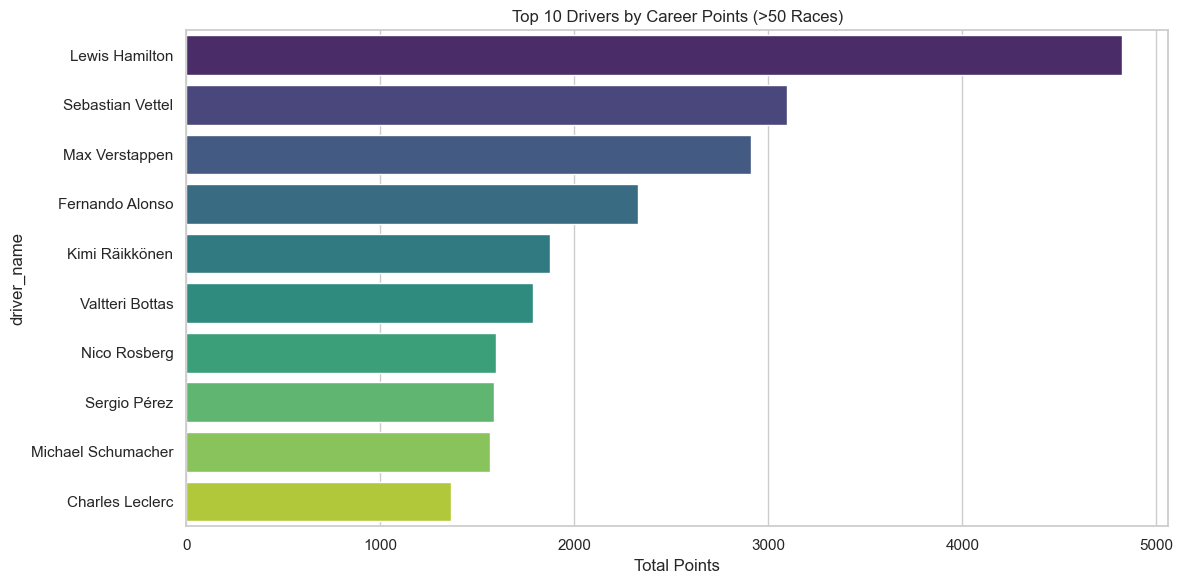

In [11]:
# 1. Top 10 Drivers by Total Points
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, x='total_points', y='driver_name', palette='viridis')
plt.title('Top 10 Drivers by Career Points (>50 Races)')
plt.xlabel('Total Points')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/top_10_drivers_points.png")
plt.show()

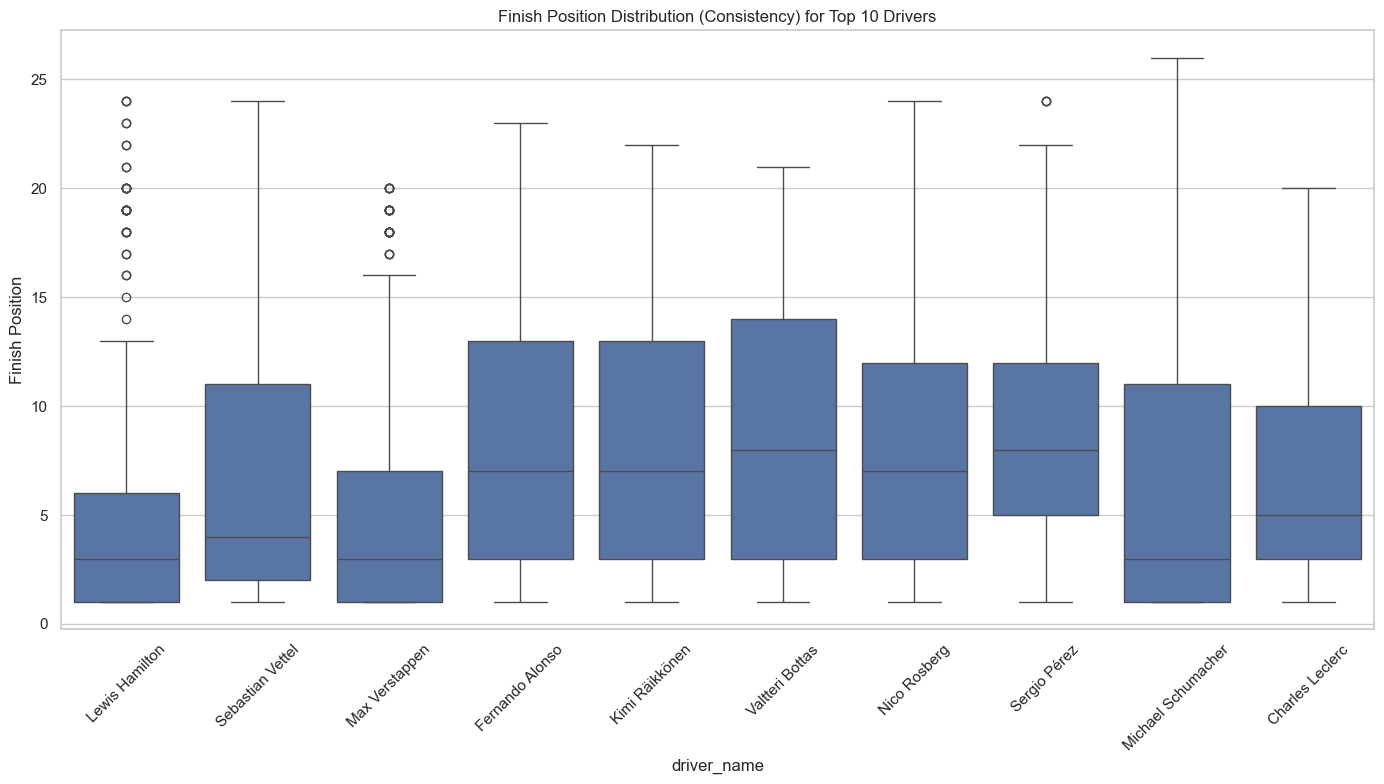

In [12]:
# 2. Consistency Analysis (Boxplot of Finish Positions for Top 10)
top_10_ids = top_10['driverId'].unique()
top_10_races = results_enriched[results_enriched['driverId'].isin(top_10_ids)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=top_10_races, x='driver_name', y='positionOrder', order=top_10['driver_name'])
plt.title('Finish Position Distribution (Consistency) for Top 10 Drivers')
plt.xticks(rotation=45)
plt.ylabel('Finish Position')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/driver_consistency_boxplot.png")
plt.show()

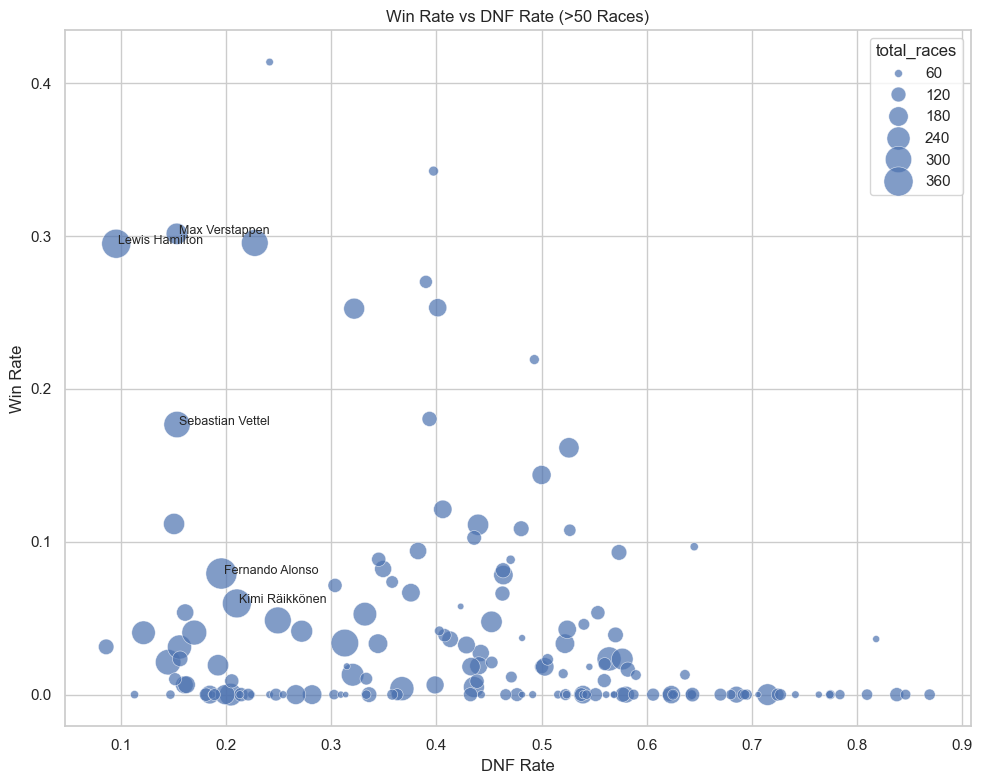

In [13]:
# 3. DNF Rate vs Win Rate Scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(data=active_drivers, x='dnf_rate', y='win_rate', size='total_races', sizes=(20, 500), alpha=0.7)

# Label top drivers
for i, row in active_drivers.head(5).iterrows():
    plt.text(row['dnf_rate']+0.002, row['win_rate'], row['driver_name'], fontsize=9)
    
plt.title('Win Rate vs DNF Rate (>50 Races)')
plt.xlabel('DNF Rate')
plt.ylabel('Win Rate')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/win_vs_dnf_scatter.png")
plt.show()

/var/folders/8h/2y7xz9gx3xb4c1bvtgwl9xqh0000gn/T/ipykernel_74159/2473164363.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='podium_rate', y='driver_name', palette='magma')


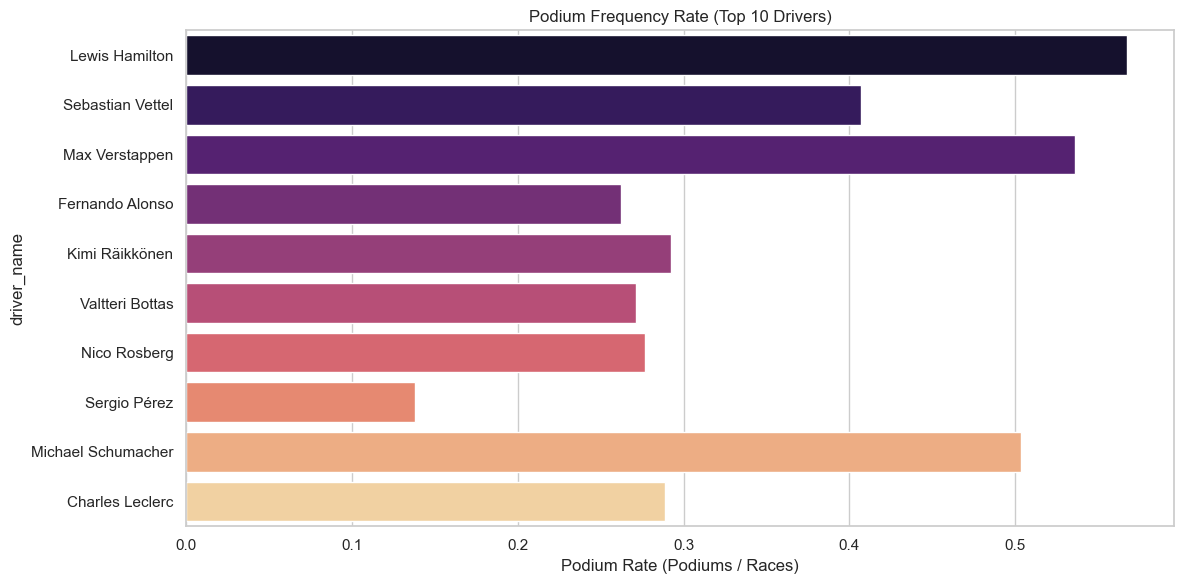

Charts saved to charts


In [14]:
# 4. Podium Frequency Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, x='podium_rate', y='driver_name', palette='magma')
plt.title('Podium Frequency Rate (Top 10 Drivers)')
plt.xlabel('Podium Rate (Podiums / Races)')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/top_10_podium_rate.png")
plt.show()

print(f"Charts saved to {OUTPUT_DIR}")

## Generate Intelligence Report

In [15]:
def generate_report(driver_stats):
    print("\n--- Generating Report ---")
    
    top_points = driver_stats.sort_values('total_points', ascending=False).head(5)
    most_consistent = driver_stats[driver_stats['total_races'] > 50].sort_values('global_consistency').head(5)
    highest_win_rate = driver_stats[driver_stats['total_races'] > 50].sort_values('win_rate', ascending=False).head(5)
    
    report = f"""# F1 Driver Performance Intelligence Report

## Overview
This report analyzes driver performance across F1 history (1950-2020 dataset), creating a comprehensive view of wins, consistency, and reliability.

## 1. Top Performers (Career Points)
The following drivers have accumulated the most points in their careers (among those with >50 races):

| Driver | Races | Total Points | Wins | Podiums |
| :--- | :--- | :--- | :--- | :--- |
"""
    for _, row in top_points.iterrows():
        report += f"| {row['driver_name']} | {row['total_races']} | {row['total_points']:.1f} | {row['total_wins']} | {row['total_podiums']} |\n"
        
    report += """
## 2. Consistency Analysis
Consistency is measured by the standard deviation of finishing positions. Lower score = More consistent.

| Driver | Races | Consistency Score | Avg Finish | DNF Rate |
| :--- | :--- | :--- | :--- | :--- |
"""
    for _, row in most_consistent.iterrows():
        report += f"| {row['driver_name']} | {row['total_races']} | {row['global_consistency']:.2f} | {row['avg_finish_pos']:.1f} | {row['dnf_rate']:.2%} |\n"

    report += """
## 3. Win Efficiency
Drivers with the highest conversion rate of race starts to wins (>50 races):

| Driver | Win Rate | Wins | Races | Points/Race |
| :--- | :--- | :--- | :--- | :--- |
"""
    for _, row in highest_win_rate.iterrows():
        report += f"| {row['driver_name']} | {row['win_rate']:.2%} | {row['total_wins']} | {row['total_races']} | {row['points_per_race']:.2f} |\n"

    report += """
## 4. Visualizations

### Career Points Leaders
![Top 10 Points](../images/top_10_drivers_points.png)

### Consistency Profile
The boxplot shows the spread of finishing positions. A tighter box indicates higher consistency.
![Consistency Boxplot](../images/driver_consistency_boxplot.png)

### Reliability vs Success
Mapping DNF rates against Win rates to see the tradeoff between aggression/reliability and victory.
![Win vs DNF](../images/win_vs_dnf_scatter.png)

### Podium Frequency
Percentage of races finished on the podium.
![Podium Rate](../images/top_10_podium_rate.png)
"""
    
    with open("../reports/driver_intelligence_report.md", "w") as f:
        f.write(report)
    print("Report generated: ../reports/driver_intelligence_report.md")

In [16]:
generate_report(driver_stats)


--- Generating Report ---
Report generated: ../reports/driver_intelligence_report.md


## Summary & Next Steps

### What We Accomplished:
 Loaded 70+ years of F1 race results  
 Engineered meaningful performance metrics  
 Calculated career statistics for all drivers  
 Generated professional visualizations  
 Created an intelligence report  

### Key Outputs:
- **4 Visualizations** saved to `images/` folder:
  - Top 10 drivers by points
  - Consistency analysis (boxplot)
  - Win rate vs DNF rate scatter
  - Podium frequency bar chart
- **Intelligence Report** saved to `../reports/driver_intelligence_report.md`

### Insights You Can Extract:
1. **Who are the GOATs?** (Greatest Of All Time)
   - Look at top performers in the points ranking
   
2. **Who was most consistent?**
   - Check the consistency boxplot - narrower boxes = more predictable

3. **Risk vs Reward?**
   - The DNF scatter plot shows aggressive vs conservative drivers

4. **Podium machines?**
   - Some drivers may not win much but consistently finish top 3

### Further Analysis Ideas:
- Compare performance by era (1950s vs 2000s)
- Analyze team performance (constructor analysis)
- Study driver pairings (teammate comparisons)
- Investigate age vs performance correlations